# SLIM MODEL
Since the KNN_Item_CF is the one that perfomed the best so far, now i'm trying a SLIM Model, which is basically the same algorithm but Machine Learning based. It uses the infos from the training data instead of some heuristic (such as cosine similarity ecc...)
https://notebook.community/trangel/Insight-Data-Science/general-docs/recommendation-validation/.ipynb_checkpoints/recommender_systems-validation-checkpoint

# Data loading 
Next cells are used to load the data we need.

In [15]:
import pandas as pd
import numpy as np 
import scipy.sparse as sps
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('..')


In [16]:
#data which contains users (row), items(col) and implicit interaction (data)
dataset = pd.read_csv('data_train.csv')
dataset

,row,col,data
0,0,10080,1.0
1,0,19467,1.0
2,1,2665,1.0
3,1,7494,1.0
4,1,17068,1.0
...,...,...,...
113263,7945,2476,1.0
113264,7945,12319,1.0
113265,7945,21384,1.0
113266,7946,8699,1.0


# Data pre-processing
Pre-processing of data to check for missing users, items ecc...

In [17]:
unique_users, min_users, max_users = len(dataset.row.unique()), dataset.row.min(), dataset.row.max()
unique_items, min_items, max_items = len(dataset.col.unique()), dataset.col.min(), dataset.col.max()
print('users stats:',unique_users, min_users, max_users)
print('items stats:',unique_items, min_items, max_items)

users stats: 7947 0 7946
items stats: 24896 0 25974


If the difference between the unique elements and the max/min ones is really big, it's better to remap users and items in a new dataframe. In this case, it seems I can leave it as it is

In [18]:
users = dataset.row
items = dataset.col
data = dataset.data
URM_all = sps.coo_matrix((data, (users, items)))
URM_all = URM_all.tocsr() #fast row access -> fast access to users 
URM_all.shape

(7947, 25975)

CSR basically has a pointer to the exact beginning of every possible row. For example if i have <code>matrix.inptr = [0,1,2,4,6] </code> this means that at <code>matrix.inptr[n]</code> I have my n row which "last" until the next cell in the array. <br> In this case (for example) my third row goes from 2 to 4. <br>

What do I do with it? <br>

I use this index (2 to 4) to access the other two arrays of the crs format: <code>indices</code> and <code>data</code>.
<code>indices</code> gives me the column index and <code>data</code> gives me the actual data to take

In [19]:
items_per_user = np.ediff1d(URM_all.indptr) #tells in which position each of the rows begin
users_per_item = np.ediff1d(sps.csc_matrix(URM_all).indptr)
URM_all = sps.csr_matrix(URM_all)

In [20]:
items_per_user = np.sort(items_per_user) #sorting based on the single value. Losing reference to the user. 
users_per_item = np.sort(users_per_item)

The following 2 graphs plots the <code>items_per_user</code> and the <code>users_per_item</code>. It shows that slightly more than 2500 users and 2500 items have a 0 count. This is coherent with the original data we got: 30910-27255 for users and 18494-15277 for items. These differences are the missing users/items in the dataset (Basically users/items that have no interaction at all)

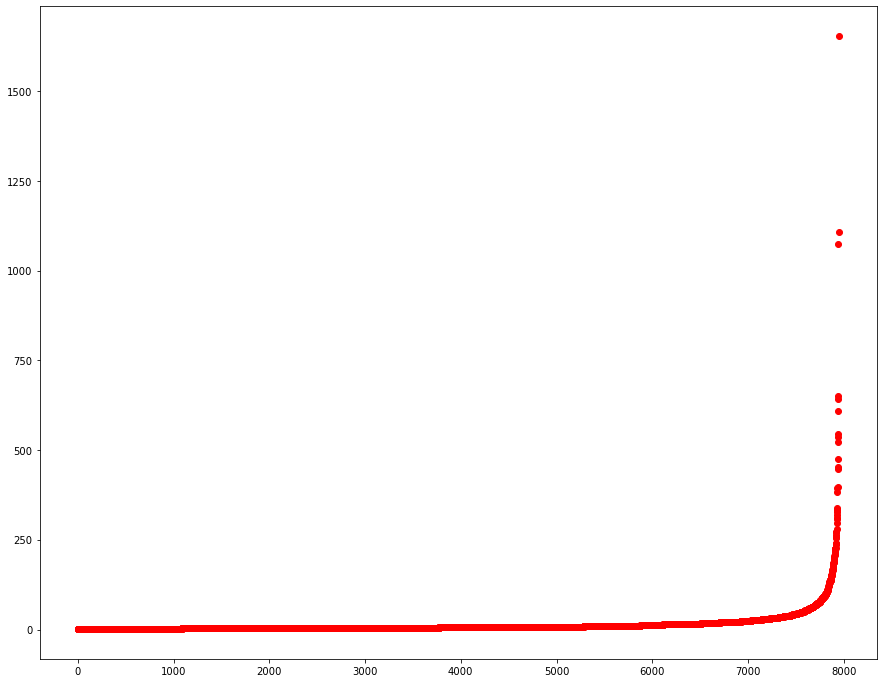

In [21]:
plt.figure(figsize=(15,12))
plt.plot(items_per_user, 'ro') #biased dataset, but not so much compared with the one seen at lessons 

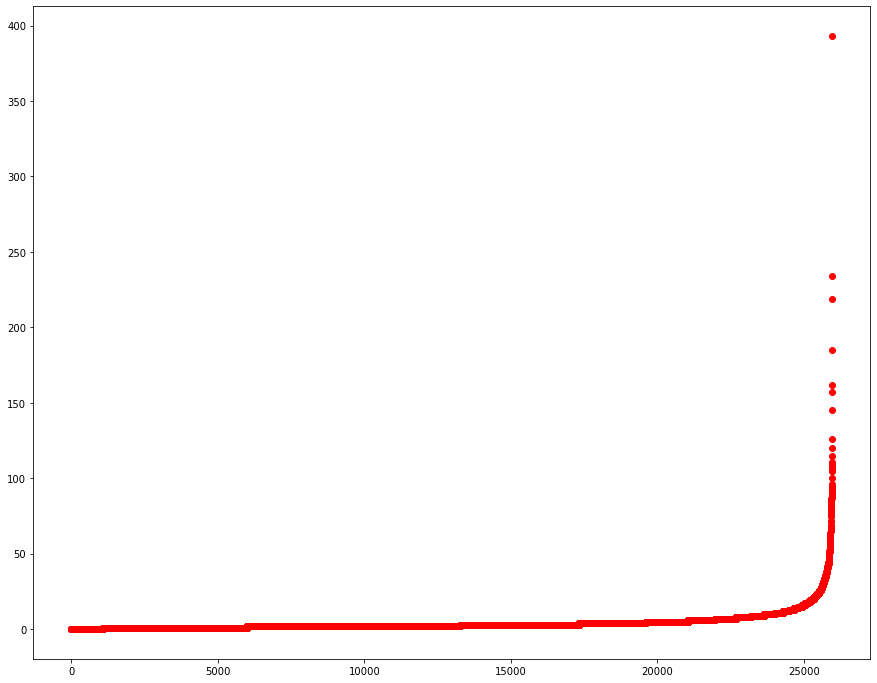

In [22]:
plt.figure(figsize=(15,12))
plt.plot(users_per_item, 'ro') #biased dataset, but not so much compared with the one seen at lessons 

In [23]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

#splitting data into train and test. In teoria non serve, da vedere
#URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)

#splitting data into train and validation (from the previous training data)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)



In [24]:
#evaluator for validation (used for hyperparameter tuning)
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

#evaluator for testing (the final one)
#evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

In [30]:
from SLIM_BPR.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython

recommender = SLIM_BPR_Cython(URM_train, recompile_cython=False)

SLIM_BPR_Recommender: URM Detected 40 (0.50 %) cold users.
SLIM_BPR_Recommender: URM Detected 2022 (7.78 %) cold items.


In [60]:
x_tick = []
collaborative_MAP = []

for topK in [200,250,300,350]:

        
    x_tick.append("topk {}".format(topK))

        
    recommender = SLIM_BPR_Cython(URM_train, recompile_cython=False)
    
    #remember to specify the positive threshold
    recommender.fit(epochs=300, batch_size=1000, sgd_mode='sgd', learning_rate=1e-4, positive_threshold_BPR=1,  topK = topK)
    
    result_dict, _ = evaluator_validation.evaluateRecommender(recommender)
    
    collaborative_MAP.append(result_dict[10]["MAP"])

SLIM_BPR_Recommender: URM Detected 40 (0.50 %) cold users.
SLIM_BPR_Recommender: URM Detected 2022 (7.78 %) cold items.
Deallocating Cython objects
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 7947 ( 100.00% ) in 0.40 seconds. BPR loss is 2.10E-08. Sample per second: 19731
SLIM_BPR_Recommender: Epoch 1 of 300. Elapsed time 0.03 sec
Processed 7947 ( 100.00% ) in 0.43 seconds. BPR loss is 7.23E-08. Sample per second: 18407
SLIM_BPR_Recommender: Epoch 2 of 300. Elapsed time 0.06 sec
Processed 7947 ( 100.00% ) in 0.46 seconds. BPR loss is 1.73E-07. Sample per second: 17400
SLIM_BPR_Recommender: Epoch 3 of 300. Elapsed time 0.08 sec
Processed 7947 ( 100.00% ) in 0.48 seconds. BPR loss is 3.53E-07. Sample per second: 16442
SLIM_BPR_Recommender: Epoch 4 of 300. Elapsed time 0.11 sec
Processed 7947 ( 100.00% ) i

Processed 7947 ( 100.00% ) in 0.05 seconds. BPR loss is 4.12E-05. Sample per second: 155907
SLIM_BPR_Recommender: Epoch 53 of 300. Elapsed time 1.68 sec
Processed 7947 ( 100.00% ) in 0.12 seconds. BPR loss is 4.77E-05. Sample per second: 67389
SLIM_BPR_Recommender: Epoch 54 of 300. Elapsed time 1.76 sec
Processed 7947 ( 100.00% ) in 0.19 seconds. BPR loss is 4.51E-05. Sample per second: 42075
SLIM_BPR_Recommender: Epoch 55 of 300. Elapsed time 1.82 sec
Processed 7947 ( 100.00% ) in 0.24 seconds. BPR loss is 4.74E-05. Sample per second: 33696
SLIM_BPR_Recommender: Epoch 56 of 300. Elapsed time 1.86 sec
Processed 7947 ( 100.00% ) in 0.27 seconds. BPR loss is 4.64E-05. Sample per second: 28917
SLIM_BPR_Recommender: Epoch 57 of 300. Elapsed time 1.90 sec
Processed 7947 ( 100.00% ) in 0.33 seconds. BPR loss is 5.28E-05. Sample per second: 24171
SLIM_BPR_Recommender: Epoch 58 of 300. Elapsed time 1.96 sec
Processed 7947 ( 100.00% ) in 0.38 seconds. BPR loss is 5.39E-05. Sample per second: 20

Processed 7947 ( 100.00% ) in 0.05 seconds. BPR loss is 1.74E-04. Sample per second: 173541
SLIM_BPR_Recommender: Epoch 107 of 300. Elapsed time 3.67 sec
Processed 7947 ( 100.00% ) in 0.08 seconds. BPR loss is 1.85E-04. Sample per second: 99618
SLIM_BPR_Recommender: Epoch 108 of 300. Elapsed time 3.70 sec
Processed 7947 ( 100.00% ) in 0.11 seconds. BPR loss is 1.77E-04. Sample per second: 73749
SLIM_BPR_Recommender: Epoch 109 of 300. Elapsed time 3.73 sec
Processed 7947 ( 100.00% ) in 0.14 seconds. BPR loss is 1.85E-04. Sample per second: 58120
SLIM_BPR_Recommender: Epoch 110 of 300. Elapsed time 3.76 sec
Processed 7947 ( 100.00% ) in 0.16 seconds. BPR loss is 2.00E-04. Sample per second: 48834
SLIM_BPR_Recommender: Epoch 111 of 300. Elapsed time 3.79 sec
Processed 7947 ( 100.00% ) in 0.19 seconds. BPR loss is 1.80E-04. Sample per second: 42562
SLIM_BPR_Recommender: Epoch 112 of 300. Elapsed time 3.81 sec
Processed 7947 ( 100.00% ) in 0.21 seconds. BPR loss is 2.07E-04. Sample per seco

Processed 7947 ( 100.00% ) in 0.36 seconds. BPR loss is 4.02E-04. Sample per second: 22209
SLIM_BPR_Recommender: Epoch 161 of 300. Elapsed time 4.98 sec
Processed 7947 ( 100.00% ) in 0.38 seconds. BPR loss is 3.77E-04. Sample per second: 21033
SLIM_BPR_Recommender: Epoch 162 of 300. Elapsed time 5.00 sec
Processed 7947 ( 100.00% ) in 0.40 seconds. BPR loss is 4.20E-04. Sample per second: 19777
SLIM_BPR_Recommender: Epoch 163 of 300. Elapsed time 5.03 sec
Processed 7947 ( 100.00% ) in 0.42 seconds. BPR loss is 4.08E-04. Sample per second: 18708
SLIM_BPR_Recommender: Epoch 164 of 300. Elapsed time 5.05 sec
Processed 7947 ( 100.00% ) in 0.45 seconds. BPR loss is 4.21E-04. Sample per second: 17747
SLIM_BPR_Recommender: Epoch 165 of 300. Elapsed time 5.07 sec
Processed 7947 ( 100.00% ) in 0.47 seconds. BPR loss is 4.05E-04. Sample per second: 16917
SLIM_BPR_Recommender: Epoch 166 of 300. Elapsed time 5.10 sec
Processed 7947 ( 100.00% ) in 0.49 seconds. BPR loss is 4.30E-04. Sample per secon

Processed 7947 ( 100.00% ) in 0.61 seconds. BPR loss is 6.98E-04. Sample per second: 12949
SLIM_BPR_Recommender: Epoch 215 of 300. Elapsed time 6.24 sec
Processed 7947 ( 100.00% ) in 0.64 seconds. BPR loss is 6.84E-04. Sample per second: 12443
SLIM_BPR_Recommender: Epoch 216 of 300. Elapsed time 6.26 sec
Processed 7947 ( 100.00% ) in 0.67 seconds. BPR loss is 6.94E-04. Sample per second: 11832
SLIM_BPR_Recommender: Epoch 217 of 300. Elapsed time 6.30 sec
Processed 7947 ( 100.00% ) in 0.69 seconds. BPR loss is 7.19E-04. Sample per second: 11440
SLIM_BPR_Recommender: Epoch 218 of 300. Elapsed time 6.32 sec
Processed 7947 ( 100.00% ) in 0.72 seconds. BPR loss is 7.30E-04. Sample per second: 11059
SLIM_BPR_Recommender: Epoch 219 of 300. Elapsed time 6.34 sec
Processed 7947 ( 100.00% ) in 0.74 seconds. BPR loss is 7.44E-04. Sample per second: 10730
SLIM_BPR_Recommender: Epoch 220 of 300. Elapsed time 6.36 sec
Processed 7947 ( 100.00% ) in 0.76 seconds. BPR loss is 7.64E-04. Sample per secon

Processed 7947 ( 100.00% ) in 1.00 seconds. BPR loss is 1.06E-03. Sample per second: 7981
SLIM_BPR_Recommender: Epoch 269 of 300. Elapsed time 7.62 sec
Processed 7947 ( 100.00% ) in 1.02 seconds. BPR loss is 1.14E-03. Sample per second: 7801
SLIM_BPR_Recommender: Epoch 270 of 300. Elapsed time 7.64 sec
Processed 7947 ( 100.00% ) in 0.05 seconds. BPR loss is 1.19E-03. Sample per second: 173476
SLIM_BPR_Recommender: Epoch 271 of 300. Elapsed time 7.67 sec
Processed 7947 ( 100.00% ) in 0.07 seconds. BPR loss is 1.03E-03. Sample per second: 112258
SLIM_BPR_Recommender: Epoch 272 of 300. Elapsed time 7.70 sec
Processed 7947 ( 100.00% ) in 0.10 seconds. BPR loss is 1.02E-03. Sample per second: 82964
SLIM_BPR_Recommender: Epoch 273 of 300. Elapsed time 7.72 sec
Processed 7947 ( 100.00% ) in 0.12 seconds. BPR loss is 1.20E-03. Sample per second: 65263
SLIM_BPR_Recommender: Epoch 274 of 300. Elapsed time 7.75 sec
Processed 7947 ( 100.00% ) in 0.14 seconds. BPR loss is 1.17E-03. Sample per secon

Processed 7947 ( 100.00% ) in 0.49 seconds. BPR loss is 5.58E-06. Sample per second: 16269
SLIM_BPR_Recommender: Epoch 19 of 300. Elapsed time 0.50 sec
Processed 7947 ( 100.00% ) in 0.52 seconds. BPR loss is 5.87E-06. Sample per second: 15329
SLIM_BPR_Recommender: Epoch 20 of 300. Elapsed time 0.53 sec
Processed 7947 ( 100.00% ) in 0.55 seconds. BPR loss is 7.12E-06. Sample per second: 14571
SLIM_BPR_Recommender: Epoch 21 of 300. Elapsed time 0.56 sec
Processed 7947 ( 100.00% ) in 0.57 seconds. BPR loss is 8.16E-06. Sample per second: 13859
SLIM_BPR_Recommender: Epoch 22 of 300. Elapsed time 0.58 sec
Processed 7947 ( 100.00% ) in 0.60 seconds. BPR loss is 8.42E-06. Sample per second: 13303
SLIM_BPR_Recommender: Epoch 23 of 300. Elapsed time 0.61 sec
Processed 7947 ( 100.00% ) in 0.62 seconds. BPR loss is 9.26E-06. Sample per second: 12810
SLIM_BPR_Recommender: Epoch 24 of 300. Elapsed time 0.63 sec
Processed 7947 ( 100.00% ) in 0.65 seconds. BPR loss is 9.83E-06. Sample per second: 122

Processed 7947 ( 100.00% ) in 0.87 seconds. BPR loss is 7.55E-05. Sample per second: 9141
SLIM_BPR_Recommender: Epoch 73 of 300. Elapsed time 1.88 sec
Processed 7947 ( 100.00% ) in 0.90 seconds. BPR loss is 7.72E-05. Sample per second: 8866
SLIM_BPR_Recommender: Epoch 74 of 300. Elapsed time 1.91 sec
Processed 7947 ( 100.00% ) in 0.92 seconds. BPR loss is 8.96E-05. Sample per second: 8649
SLIM_BPR_Recommender: Epoch 75 of 300. Elapsed time 1.93 sec
Processed 7947 ( 100.00% ) in 0.95 seconds. BPR loss is 8.69E-05. Sample per second: 8402
SLIM_BPR_Recommender: Epoch 76 of 300. Elapsed time 1.95 sec
Processed 7947 ( 100.00% ) in 0.97 seconds. BPR loss is 9.17E-05. Sample per second: 8203
SLIM_BPR_Recommender: Epoch 77 of 300. Elapsed time 1.98 sec
Processed 7947 ( 100.00% ) in 0.99 seconds. BPR loss is 9.49E-05. Sample per second: 8013
SLIM_BPR_Recommender: Epoch 78 of 300. Elapsed time 2.00 sec
Processed 7947 ( 100.00% ) in 1.02 seconds. BPR loss is 1.01E-04. Sample per second: 7824
SLIM

SLIM_BPR_Recommender: Epoch 126 of 300. Elapsed time 3.21 sec
Processed 7947 ( 100.00% ) in 0.23 seconds. BPR loss is 2.32E-04. Sample per second: 34624
SLIM_BPR_Recommender: Epoch 127 of 300. Elapsed time 3.24 sec
Processed 7947 ( 100.00% ) in 0.25 seconds. BPR loss is 2.34E-04. Sample per second: 31225
SLIM_BPR_Recommender: Epoch 128 of 300. Elapsed time 3.26 sec
Processed 7947 ( 100.00% ) in 0.28 seconds. BPR loss is 2.55E-04. Sample per second: 28612
SLIM_BPR_Recommender: Epoch 129 of 300. Elapsed time 3.29 sec
Processed 7947 ( 100.00% ) in 0.30 seconds. BPR loss is 2.52E-04. Sample per second: 26252
SLIM_BPR_Recommender: Epoch 130 of 300. Elapsed time 3.31 sec
Processed 7947 ( 100.00% ) in 0.33 seconds. BPR loss is 2.56E-04. Sample per second: 24104
SLIM_BPR_Recommender: Epoch 131 of 300. Elapsed time 3.34 sec
Processed 7947 ( 100.00% ) in 0.35 seconds. BPR loss is 2.71E-04. Sample per second: 22392
SLIM_BPR_Recommender: Epoch 132 of 300. Elapsed time 3.36 sec
Processed 7947 ( 100

SLIM_BPR_Recommender: Epoch 180 of 300. Elapsed time 4.56 sec
Processed 7947 ( 100.00% ) in 0.58 seconds. BPR loss is 4.92E-04. Sample per second: 13754
SLIM_BPR_Recommender: Epoch 181 of 300. Elapsed time 4.59 sec
Processed 7947 ( 100.00% ) in 0.61 seconds. BPR loss is 4.82E-04. Sample per second: 13097
SLIM_BPR_Recommender: Epoch 182 of 300. Elapsed time 4.62 sec
Processed 7947 ( 100.00% ) in 0.63 seconds. BPR loss is 4.90E-04. Sample per second: 12639
SLIM_BPR_Recommender: Epoch 183 of 300. Elapsed time 4.64 sec
Processed 7947 ( 100.00% ) in 0.65 seconds. BPR loss is 4.93E-04. Sample per second: 12193
SLIM_BPR_Recommender: Epoch 184 of 300. Elapsed time 4.66 sec
Processed 7947 ( 100.00% ) in 0.68 seconds. BPR loss is 4.95E-04. Sample per second: 11709
SLIM_BPR_Recommender: Epoch 185 of 300. Elapsed time 4.69 sec
Processed 7947 ( 100.00% ) in 0.70 seconds. BPR loss is 5.01E-04. Sample per second: 11325
SLIM_BPR_Recommender: Epoch 186 of 300. Elapsed time 4.71 sec
Processed 7947 ( 100

SLIM_BPR_Recommender: Epoch 234 of 300. Elapsed time 5.90 sec
Processed 7947 ( 100.00% ) in 0.91 seconds. BPR loss is 8.03E-04. Sample per second: 8692
SLIM_BPR_Recommender: Epoch 235 of 300. Elapsed time 5.93 sec
Processed 7947 ( 100.00% ) in 0.95 seconds. BPR loss is 8.04E-04. Sample per second: 8354
SLIM_BPR_Recommender: Epoch 236 of 300. Elapsed time 5.96 sec
Processed 7947 ( 100.00% ) in 0.98 seconds. BPR loss is 8.13E-04. Sample per second: 8115
SLIM_BPR_Recommender: Epoch 237 of 300. Elapsed time 5.99 sec
Processed 7947 ( 100.00% ) in 1.01 seconds. BPR loss is 8.33E-04. Sample per second: 7851
SLIM_BPR_Recommender: Epoch 238 of 300. Elapsed time 6.02 sec
Processed 7947 ( 100.00% ) in 0.04 seconds. BPR loss is 8.52E-04. Sample per second: 206297
SLIM_BPR_Recommender: Epoch 239 of 300. Elapsed time 6.05 sec
Processed 7947 ( 100.00% ) in 0.06 seconds. BPR loss is 8.41E-04. Sample per second: 131368
SLIM_BPR_Recommender: Epoch 240 of 300. Elapsed time 6.07 sec
Processed 7947 ( 100.0

Processed 7947 ( 100.00% ) in 0.32 seconds. BPR loss is 1.22E-03. Sample per second: 25218
SLIM_BPR_Recommender: Epoch 288 of 300. Elapsed time 7.32 sec
Processed 7947 ( 100.00% ) in 0.34 seconds. BPR loss is 1.22E-03. Sample per second: 23643
SLIM_BPR_Recommender: Epoch 289 of 300. Elapsed time 7.35 sec
Processed 7947 ( 100.00% ) in 0.36 seconds. BPR loss is 1.18E-03. Sample per second: 21885
SLIM_BPR_Recommender: Epoch 290 of 300. Elapsed time 7.37 sec
Processed 7947 ( 100.00% ) in 0.39 seconds. BPR loss is 1.18E-03. Sample per second: 20529
SLIM_BPR_Recommender: Epoch 291 of 300. Elapsed time 7.40 sec
Processed 7947 ( 100.00% ) in 0.41 seconds. BPR loss is 1.27E-03. Sample per second: 19193
SLIM_BPR_Recommender: Epoch 292 of 300. Elapsed time 7.42 sec
Processed 7947 ( 100.00% ) in 0.45 seconds. BPR loss is 1.27E-03. Sample per second: 17856
SLIM_BPR_Recommender: Epoch 293 of 300. Elapsed time 7.45 sec
Processed 7947 ( 100.00% ) in 0.47 seconds. BPR loss is 1.29E-03. Sample per secon

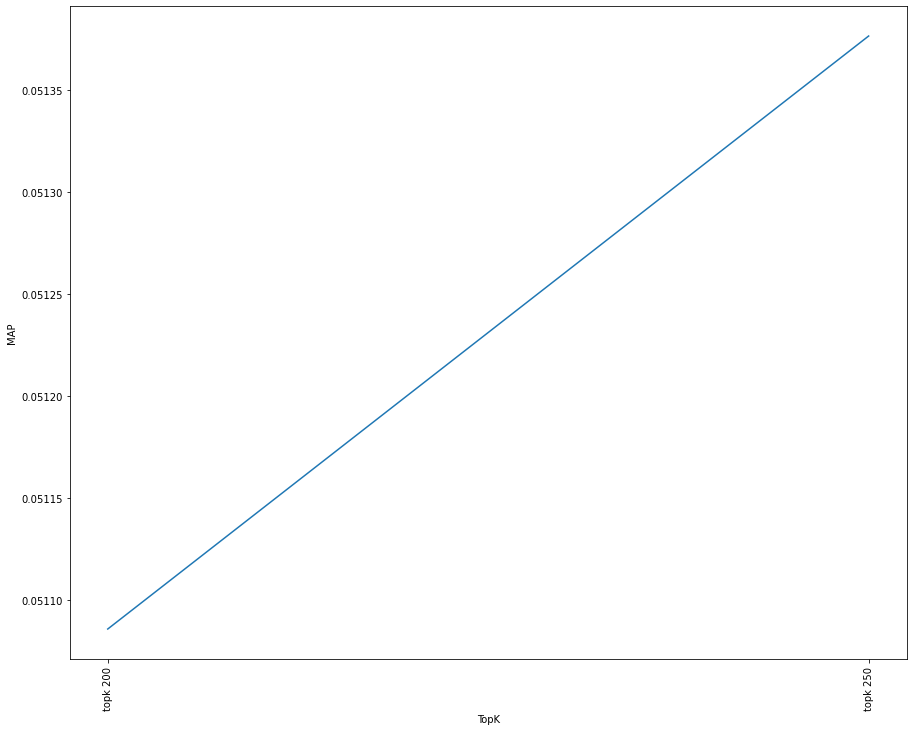

In [61]:
plt.figure(figsize=(15,12))
plt.plot(x_tick, collaborative_MAP, label="Collaborative", )
plt.ylabel('MAP')
plt.xlabel('TopK')
plt.xticks(rotation='vertical')
plt.show()

In [59]:
test_users = pd.read_csv('data_target_users_test.csv')
test_users

,user_id
0,0
1,1
2,2
3,3
4,4
...,...
7939,7942
7940,7943
7941,7944
7942,7945


In [31]:
recommender = SLIM_BPR_Cython(URM_train, recompile_cython=False)
#remember to specify the positive threshold
recommender.fit(epochs=300, batch_size=1000, sgd_mode='sgd', learning_rate=1e-4, positive_threshold_BPR=1, topK=100)
user_id = test_users['user_id']
recommendations = recommender.recommend(user_id,cutoff = 10)


ItemKNNCFRecommender: URM Detected 1079 (4.15 %) cold items.
Similarity column 25975 ( 100 % ), 5538.05 column/sec, elapsed time 0.08 min


In [32]:
for index in range(len(recommendations)):
    #print(element)
    recommendations[index]=np.array(recommendations[index])
    #print(type(element))
print(len(recommendations))

7944


In [33]:
test_users['item_list']= recommendations
#test_users['item_list'] =  test_users['item_list'].apply(lambda x: x.replace('[','').replace(']','')) 
test_users['item_list'] = pd.DataFrame([str(line).strip('[').strip(']').replace("'","") for line in test_users['item_list']])

#convert the string columns to int
#test_users['item_list'] = test_users['item_list'].astype(int)
test_users
test_users.to_csv('submission.csv', index=False)
